<a href="https://colab.research.google.com/github/J-oyin/Dr.-Jimoh-Analysis/blob/main/Morris-Water-Maize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

In [110]:
data = pd.read_excel("/content/Dr. J_MWM.xlsx")

In [111]:
data.head()

,S/N,Group,Latency,conditions,Subject
0,1,Healthy,19,baseline,RC1
1,2,Healthy,16,baseline,RC2
2,3,Healthy,8,baseline,RC3
3,4,Healthy,4,baseline,RC4
4,5,Healthy,5,baseline,RC5


In [112]:
stat, p = shapiro(data['Latency'])
print(f"Shapiro-Wilk Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Data is normally distributed")
else:
    print("Data is NOT normally distributed")


Shapiro-Wilk Test: stat=0.779, p=0.000
Data is NOT normally distributed


In [113]:
from scipy.stats import levene

grouped = [data[data['Group']==grp]['Latency'].values for grp in
           ['Healthy', 'Resilient', 'S/DW', 'S/RG108', 'S/Esc',
            'S/LASA', 'S/LASA+ESC', 'S/HASA', 'S/HASA+ESC']]

stat, p = levene(*grouped)
print(f"Levene Test: stat={stat:.3f}, p={p:.3f}")

if p > 0.05:
    print("Variances are homogeneous across groups")
else:
    print("Variances are NOT homogeneous across groups")


Levene Test: stat=nan, p=nan
Variances are NOT homogeneous across groups


/tmp/ipython-input-2499676642.py:7: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p = levene(*grouped)


In [114]:
df = data

In [115]:
df.head(10)

,S/N,Group,Latency,conditions,Subject
0,1,Healthy,19,baseline,RC1
1,2,Healthy,16,baseline,RC2
2,3,Healthy,8,baseline,RC3
3,4,Healthy,4,baseline,RC4
4,5,Healthy,5,baseline,RC5
5,6,Healthy,8,post.indt,RC1
6,7,Healthy,60,post.indt,RC2
7,8,Healthy,5,post.indt,RC3
8,9,Healthy,17,post.indt,RC4
9,10,Healthy,16,post.indt,RC5


In [116]:
from scipy.stats import friedmanchisquare

# Create an empty list to collect results
results = []

# Loop over each group and run the Friedman test
for grp, data in df.groupby('Group'):
    # Pivot data so each condition becomes a column (subjects as rows)
    pivot = data.pivot(index='Subject', columns='conditions', values='Latency')

    # Ensure conditions are in correct order
    pivot = pivot[['baseline', 'post.indt', 'post.tret']]

    # Run Friedman test
    stat, p = friedmanchisquare(pivot['baseline'], pivot['post.indt'], pivot['post.tret'])

    # Save results
    results.append({'Group': grp, 'Chi-square': stat, 'p-value': p})

# Convert results to dataframe
friedman_results = pd.DataFrame(results)
print(friedman_results)


       Group  Chi-square   p-value
0    Healthy    1.368421  0.504488
1  Resilient    2.631579  0.268262
2       S/DW    4.105263  0.128397
3      S/Esc    2.842105  0.241460
4     S/HASA    2.800000  0.246597
5     S/LASA    7.600000  0.022371


In [117]:

# ------- choose outcome variable -------
dv = 'Latency'   # change this to any measure you like

# ------- function to build the table -------
def make_desc_table(data, group_cols, dv):
    g = data.groupby(group_cols)[dv]

    desc = g.agg(
        N='count',
        Mean='mean',
        SD='std',
        SEM=lambda x: x.std(ddof=1) / np.sqrt(x.count()),
        Median='median',
        Q1=lambda x: x.quantile(0.25),
        Q3=lambda x: x.quantile(0.75),
        Min='min',
        Max='max'
    ).reset_index()

    # IQR
    desc['IQR'] = desc['Q3'] - desc['Q1']

    # round for manuscript
    num_cols = ['Mean', 'SD', 'SEM', 'Median', 'Q1', 'Q3', 'IQR', 'Min', 'Max']
    desc[num_cols] = desc[num_cols].round(2)

    # formatted columns often reported in papers
    desc['Mean ± SD'] = desc['Mean'].astype(str) + ' ± ' + desc['SD'].astype(str)
    desc['Median (IQR)'] = (
        desc['Median'].astype(str) + ' (' +
        desc['Q1'].astype(str) + '–' +
        desc['Q3'].astype(str) + ')'
    )

    # column order
    cols_order = (
        group_cols +
        ['N', 'Mean', 'SD', 'SEM', 'Mean ± SD',
         'Median', 'Q1', 'Q3', 'IQR', 'Median (IQR)', 'Min', 'Max']
    )
    desc = desc[cols_order]

    return desc

# ------- build table: per Group × Condition -------
group_cols = ['Group', 'conditions']   # change if you want only Group, etc.
desc_table = make_desc_table(df, group_cols, dv)

print(desc_table)

# ------- export to Excel -------
output_file = f"Descriptive_stats_{dv}.xlsx"
desc_table.to_excel(output_file, index=False)
print("Saved to:", output_file)


        Group conditions  N  Mean     SD    SEM     Mean ± SD  Median    Q1  \
0     Healthy   baseline  5  10.4   6.73   3.01   10.4 ± 6.73     8.0   5.0   
1     Healthy  post.indt  5  21.2  22.29   9.97  21.2 ± 22.29    16.0   8.0   
2     Healthy  post.tret  5   8.0   3.46   1.55    8.0 ± 3.46     6.0   6.0   
3   Resilient   baseline  5  16.8   7.19   3.22   16.8 ± 7.19    15.0  14.0   
4   Resilient  post.indt  5   9.6   6.02   2.69    9.6 ± 6.02    10.0   4.0   
5   Resilient  post.tret  5  15.6  13.01   5.82  15.6 ± 13.01    13.0   7.0   
6        S/DW   baseline  5   4.6   1.14   0.51    4.6 ± 1.14     5.0   4.0   
7        S/DW  post.indt  5  18.4  13.96   6.24  18.4 ± 13.96    19.0   6.0   
8        S/DW  post.tret  5   7.0   4.80   2.14     7.0 ± 4.8     4.0   4.0   
9       S/Esc   baseline  5  17.0  14.83   6.63  17.0 ± 14.83    11.0   7.0   
10      S/Esc  post.indt  5  32.6  27.78  12.42  32.6 ± 27.78    34.0   6.0   
11      S/Esc  post.tret  5  29.0  19.66   8.79  29.

/tmp/ipython-input-1716283604.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


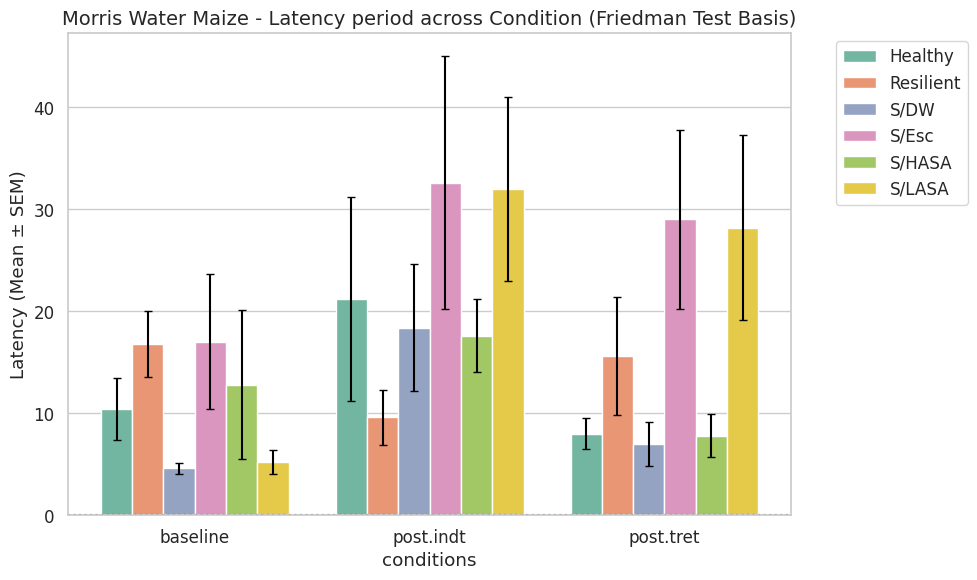

In [118]:

summary = (
    df.groupby(['Group', 'conditions'])['Latency']
      .agg(['mean', 'sem'])
      .reset_index()
)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Create the barplot (mean values)
ax = sns.barplot(
    data=summary,
    x='conditions',
    y='mean',
    hue='Group',
    ci=None,  # we are providing our own SEM
    capsize=0.1,
    palette='Set2'
)

for i, row in summary.iterrows():
    group_index = list(summary['Group'].unique()).index(row['Group'])
    cond_index = list(summary['conditions'].unique()).index(row['conditions'])
    bar = ax.patches[i]
    x = bar.get_x() + bar.get_width()/2
    y = row['mean']
    plt.errorbar(x, y, yerr=row['sem'], fmt='none', ecolor='black', capsize=3)

plt.title("Morris Water Maize - Latency period across Condition (Friedman Test Basis)", fontsize=14)
plt.ylabel("Latency (Mean ± SEM)")
plt.xlabel("conditions")
plt.axhline(color='k', ls=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
plt.tight_layout()
plt.show()


In [119]:
from scipy.stats import wilcoxon
import itertools

# Filter only the three groups
groups_of_interest = ['S/LASA']
df_sub = df[df['Group'].isin(groups_of_interest)]


In [120]:
print(df['conditions'].unique())


['baseline' 'post.indt' 'post.tret']


In [121]:
data_group = df[df['Group'] == 'Healthy']
data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Latency')
print("Pivot columns:", data_pivot.columns)


Pivot columns: Index(['baseline', 'post.indt', 'post.tret'], dtype='object', name='conditions')


In [126]:
import itertools
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

results = []
groups_to_test = ['S/LASA']

# Get all possible pairwise condition combinations
condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))

for g in groups_to_test:
    data_group = df[df['Group'] == g]

    # Pivot to wide format per subject
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Latency')

    raw_p = []          # store raw p-values for this group
    pair_labels = []    # store labels for Holm correction

    # Loop over pairs of conditions
    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()

            if len(valid) > 0:
                stat, p = wilcoxon(valid[cond1], valid[cond2])

                raw_p.append(p)
                pair_labels.append((cond1, cond2))

            else:
                print(f"⚠️ Skipped {g}: insufficient data for {cond1} vs {cond2}")
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

    # Apply Holm correction for this group
    if len(raw_p) > 0:
        reject, p_corr, _, _ = multipletests(raw_p, method='holm')

        # Save results
        for (cond1, cond2), stat_p, p_unc, p_adj, sig in zip(
            pair_labels,
            raw_p,
            raw_p,
            p_corr,
            reject
        ):
            results.append({
                'Group': g,
                'Comparison': f'{cond1} vs {cond2}',
                'p-value': p_unc,
                'p-Holm': p_adj,
                'Significant': sig
            })

# Final table
posthoc_df = pd.DataFrame(results)
print(posthoc_df)


    Group              Comparison  p-value  p-Holm  Significant
0  S/LASA   baseline vs post.indt   0.0625  0.1875        False
1  S/LASA   baseline vs post.tret   0.0625  0.1875        False
2  S/LASA  post.indt vs post.tret   1.0000  1.0000        False


In [127]:
import itertools
from scipy.stats import wilcoxon

condition_pairs = list(itertools.combinations(df['conditions'].unique(), 2))
results = []

for g in ['S/LASA']:
    data_group = df[df['Group'] == g]
    data_pivot = data_group.pivot(index='Subject', columns='conditions', values='Latency')

    for cond1, cond2 in condition_pairs:
        if cond1 in data_pivot.columns and cond2 in data_pivot.columns:
            valid = data_pivot[[cond1, cond2]].dropna()
            stat, p = wilcoxon(valid[cond1], valid[cond2])
            results.append({'Group': g, 'Comparison': f'{cond1} vs {cond2}', 'Statistic': stat, 'p-value': p})
        else:
            print(f"⚠️ Skipped {g}: missing {cond1} or {cond2}")

import pandas as pd
posthoc_df = pd.DataFrame(results)
print(posthoc_df)

    Group              Comparison  Statistic  p-value
0  S/LASA   baseline vs post.indt        0.0   0.0625
1  S/LASA   baseline vs post.tret        0.0   0.0625
2  S/LASA  post.indt vs post.tret        7.0   1.0000


In [124]:
!pip install statannotations


Pairs used: []
P-values: []


/tmp/ipython-input-2217600147.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-2217600147.py:35: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.2}` instead.

  ax = sns.barplot(


ValueError: pairs are empty after parsing: original_pairs=[]
not in group_list=[('S/LASA', 'baseline'), ('S/LASA', 'post.indt'), ('S/LASA', 'post.tret')]

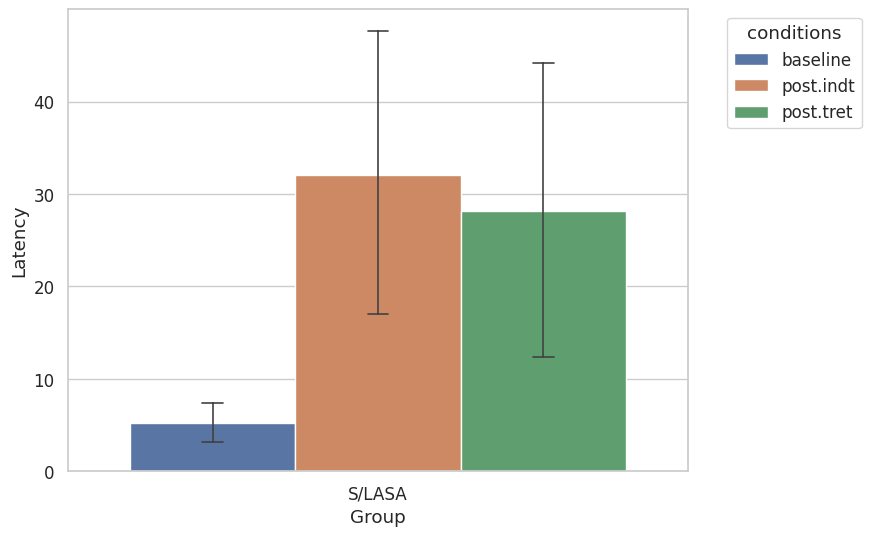

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# ── 0. If you have Holm-corrected p-values, set the column name here ──
p_col = 'p-Holm' if 'p-Holm' in posthoc_df.columns else 'p-value'

# ── 1. Split "baseline vs post.indt" into 2 condition columns ──
posthoc_df[['cond1', 'cond2']] = posthoc_df['Comparison'].str.split(' vs ', expand=True)

# ── 2. Keep only significant comparisons (you can change alpha if you like) ──
alpha = 0.05
sig_df = posthoc_df[posthoc_df[p_col] < alpha]

# ── 3. Build `pairs` and `p_values` for statannotations ──
pairs = []
p_values = []

for _, row in sig_df.iterrows():
    g = row['Group']
    c1 = row['cond1']
    c2 = row['cond2']

    # pair format is: ((x, hue), (x, hue))
    pairs.append(((g, c1), (g, c2)))
    p_values.append(row[p_col])

print("Pairs used:", pairs)
print("P-values:", p_values)

# ── 4. Plot the bars ──
plot_df = df[df['Group'].isin(['S/LASA'])]

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=plot_df,
    x='Group', y='Latency', hue='conditions',
    ci=95, capsize=0.1, errwidth=1.2
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='conditions')

# ── 5. Add significance stars from the pairs + p_values ──
annot = Annotator(
    ax,
    pairs,
    data=plot_df,
    x='Group',
    y='Latency',
    hue='conditions'
)
annot.configure(test=None, text_format='star', loc='inside', verbose=2)
annot.set_pvalues(p_values)
annot.annotate()

plt.title('Post Hoc Comparison Across Conditions')
plt.xlabel('Group')
plt.ylabel('Latency (mean ± CI)')
plt.tight_layout()
plt.show()
